In [1]:
pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast

import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)
from utils import prepare_data, TimeMoEPredictor, ChronosPredictor, LLM, wape, ProphetForecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from statsforecast.utils import ConformalIntervals

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

intervals = ConformalIntervals(h=3, n_windows=5)



/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-12 12:04:34,168	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-12 12:04:35,222	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Prepare data

In [3]:
#train, test = prepare_data(sample_size=1000,series_cutoff=72,min_series_length=60)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train["ds"] = pd.to_datetime(train["ds"])
test["ds"] = pd.to_datetime(test["ds"])

In [5]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(prediction_intervals=intervals),
    AutoETS(prediction_intervals=intervals),
    Naive(prediction_intervals=intervals)
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality'],
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [
    TimeMoEPredictor(input_length=24,device="cpu"),
    ChronosPredictor(input_length=24,device="mps"),
    ProphetForecast( train,  weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, interval_width=0.95 )
    ]


Seed set to 1
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
model_classes_custom

In [7]:
str(type(model_classes_custom[2]).__name__)


'ProphetForecast'

In [8]:
model_wrappers = {}
model_names = []

neural = True
stats = True
ML = True
custom = True

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                #lags=[1,2,3],
                #lag_transforms={
                #    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                #},
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq='ME'
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    


In [9]:
fit_times = {}

for model_name, model in model_wrappers.items():
    if isinstance(model, MLForecast):
        start = time.time()
        model.fit(df=train, prediction_intervals=intervals )
        fit_times[model_name] = time.time()-start

    elif isinstance(model, StatsForecast) or isinstance(model, NeuralForecast) or isinstance(model, ProphetForecast):
        start = time.time()
        model.fit(df=train )
        fit_times[model_name] = time.time()-start    

DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpofw7ch6z/j__paaj_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmp1d1aw6y6/dwt55k46.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmp8tudxik4/o56synyq.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpfhja2ud8/mjwrtcbx.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmp4npnmom3/e3goqyp6.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpofw7ch6z/s09fui4j.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpqly8vhc4/0l8m4w7z.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmp8tudxik4/ivk9w7oh.json
DEBUG:cmdstanpy:input tempfile: /var/folders/2z/r4rjm4611fx7hfd4yth093t40000gq/T/tmpfhja2ud8/3j40s28l.json
DEBUG:cmdstanpy:input tempfile: /var/

Epoch 32:  26%|██▌       | 8/31 [00:00<00:00, 41.93it/s, v_num=10, train_loss_step=260.0, train_loss_epoch=362.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 32:  26%|██▌       | 8/31 [00:00<00:00, 41.62it/s, v_num=10, train_loss_step=260.0, train_loss_epoch=362.0]


In [ ]:
forecast_dict = {}
forecast_times = {}

levels = [95]

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3,level=levels),model_name)
    elif isinstance(model, ProphetForecast):
        add_model(model.predict(test,h=3),model_name)      
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times[model_name] = time.time()-start

    forecast_times[model_name] = time.time()-start


MLForecast(models=[LGBMRegressor], freq=ME, lag_features=[], date_features=['dayofweek'], num_threads=1)
MLForecast(models=[LinearRegression], freq=ME, lag_features=[], date_features=['dayofweek'], num_threads=1)


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future vers

In [11]:
forecast_times

{'TimeMoEPredictor': 5.2264509201049805,
 'ChronosPredictor': 0.5058150291442871,
 'ProphetForecast': 221.3791742324829}

In [12]:
train

,unique_id,y,ds
0,M10000,2740.0,2013-04-30 12:00:00
1,M10000,3000.0,2013-05-31 12:00:00
2,M10000,3040.0,2013-06-30 12:00:00
3,M10000,2920.0,2013-07-31 12:00:00
4,M10000,2870.0,2013-08-31 12:00:00
...,...,...,...
43600,M9964,700.0,2016-08-31 12:00:00
43601,M9964,630.0,2016-09-30 12:00:00
43602,M9964,630.0,2016-10-31 12:00:00
43603,M9964,610.0,2016-11-30 12:00:00


In [13]:
weights = (
    train
        .groupby("unique_id",)["y"]
        .sum()
        .rename("weights")
)

weights = weights/weights.sum()

In [14]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [15]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [16]:
(
    test
        .filter(regex='95|index')
        .melt(id_vars="index")
        .assign(
            model=lambda x: x["variable"].str.split("-", n=1, expand=True)[0],
            d=lambda x: x["variable"].str.split("-", n=1, expand=True)[1]
        )
        .pivot(index = ["index","model"], columns="d",values="value")
        .assign(
            width = lambda x : x["hi-95"]-x["lo-95"]
        )
        .groupby(["model"])["width"]
        .median()
        .sort_values()
)

model
ProphetForecast    408.749708
Name: width, dtype: float64

In [17]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [18]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,TimeMoEPredictor,ChronosPredictor,ProphetForecast
967,M10000,wape,2612.333333,0.209031,0.175989,0.345380
968,M10127,wape,277.000000,0.020023,0.013426,0.009627
969,M1013,wape,339.000000,0.220727,0.119385,0.152348
970,M10176,wape,335.536667,0.062621,0.064004,0.011879
971,M10280,wape,556.666667,0.006427,0.010783,0.226274
...,...,...,...,...,...,...
1929,M9825,wape,0.045051,0.065976,0.090920,1.468164
1930,M983,wape,1.039595,0.035509,0.016283,0.028811
1931,M9922,wape,0.717144,0.108199,0.171973,0.027779
1932,M9942,wape,0.483115,0.142813,0.119430,0.246623


In [19]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.182960  0.398038  0.181170  0.335771
  mase    0.182960  1.000000  0.233795  0.997764  0.151383
  rmse    0.398038  0.233795  1.000000  0.237541  0.584418
  rmsse   0.181170  0.997764  0.237541  1.000000  0.148835
  wape    0.335771  0.151383  0.584418  0.148835  1.000000

In [20]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   2901.000000  2907.000000   2901.000000  2907.000000  2901.000000
mean       0.166642     1.035133    582.017468     0.920069     0.145586
std        0.510920     5.202972   1320.613120     4.332892     0.385878
min        0.000148     0.000000      0.226141     0.000000     0.000148
25%        0.015837     0.309593     65.558292     0.294828     0.015981
50%        0.044946     0.626756    183.773382     0.586642     0.045308
75%        0.148293     1.093275    519.422338     0.982165     0.149496
max       11.796137   228.669084  19604.535926   192.340037     9.124630

In [21]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

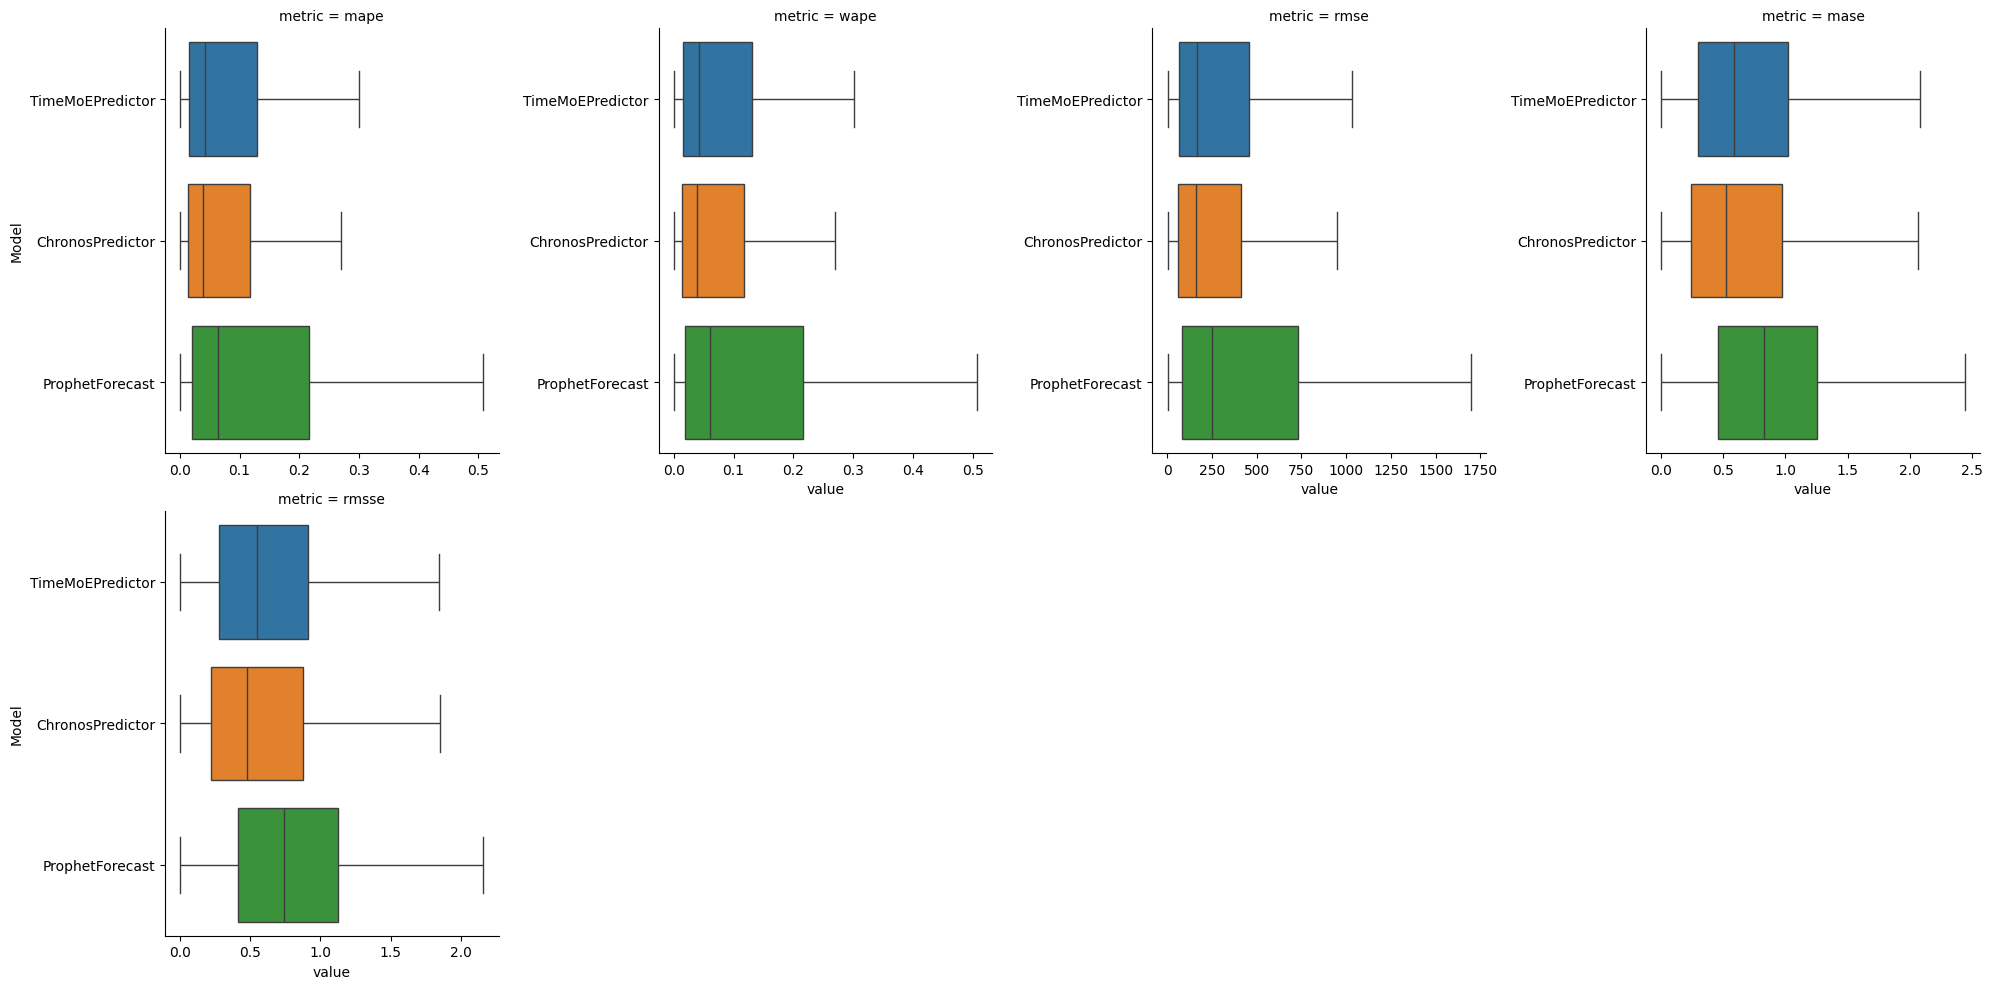

In [22]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [23]:
fit_times = pd.DataFrame.from_records([fit_times])
forecast_times = pd.DataFrame.from_records([forecast_times])

In [24]:
fit_times = fit_times.melt(var_name="Model",value_name="fit").set_index("Model")

forecast_times = forecast_times.melt(var_name="Model",value_name="forecast").set_index("Model")

In [25]:
metrics.groupby(level=[1,2]).median().unstack()

Model,ChronosPredictor,ProphetForecast,TimeMoEPredictor
metric,,,
mape,0.039046,0.063236,0.041313
mase,0.521422,0.828617,0.588456
rmse,159.598846,249.867900,163.381655
rmsse,0.478118,0.744571,0.545962
wape,0.039810,0.061124,0.041810


In [26]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(fit_times).join(forecast_times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

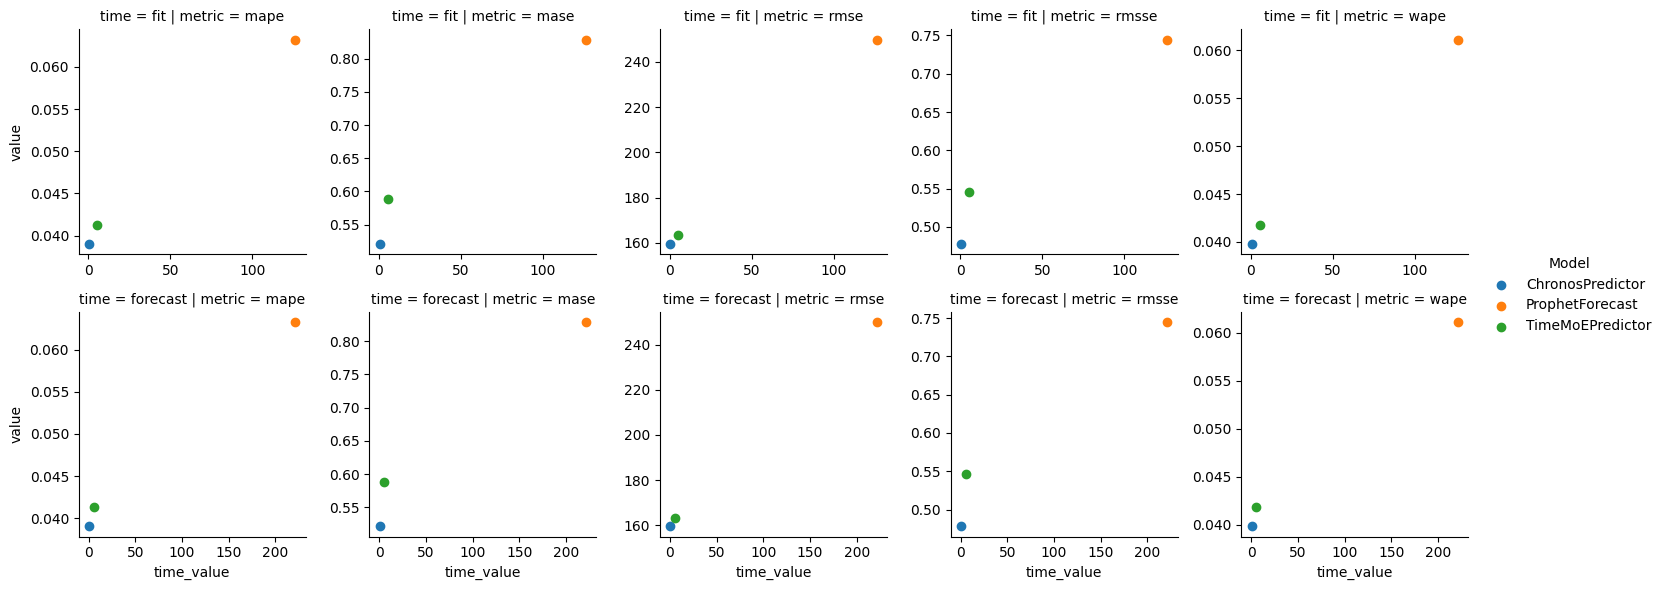

In [27]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

In [28]:
(
    metrics
        #[metrics.index.get_level_values(level=1).isin(["rmsse","rmse","mape","wape"])]
        .reset_index().merge(weights, on = "unique_id")
        .assign(metric = lambda x : "w"+x["metric"],
                value = lambda x : x.value*x.weights
                )
        .groupby(["metric","Model"])["value"]
        .sum()
        .sort_values()
        .unstack(level=0)
        .reset_index()
        .sort_values(by="wrmsse")
)

metric,Model,wmape,wmase,wrmse,wrmsse,wwape
0,ChronosPredictor,0.121274,0.747076,651.501328,0.681465,0.097916
2,TimeMoEPredictor,0.119114,0.767602,644.853854,0.697889,0.096406
1,ProphetForecast,0.193375,1.435110,996.733913,1.267767,0.202233


In [29]:
df = metrics.unstack(level=1).reset_index().drop(columns=["unique_id"])

In [30]:
from itertools import product
from scipy import stats
import pandas as pd

cols = df.columns.difference(['Model'])

g = df.groupby('Model')[cols]

out = pd.concat({(a, b): pd.DataFrame(stats.ttest_rel(g.get_group(a), g.get_group(b),alternative="less"),
                                      columns=cols, index=['statistic', 'pvalue'])
                 for a, b in product(df['Model'].unique(), repeat=2)
                }, names=['product1', 'product2'])


<Axes: xlabel='None-product2', ylabel='product1-metric'>

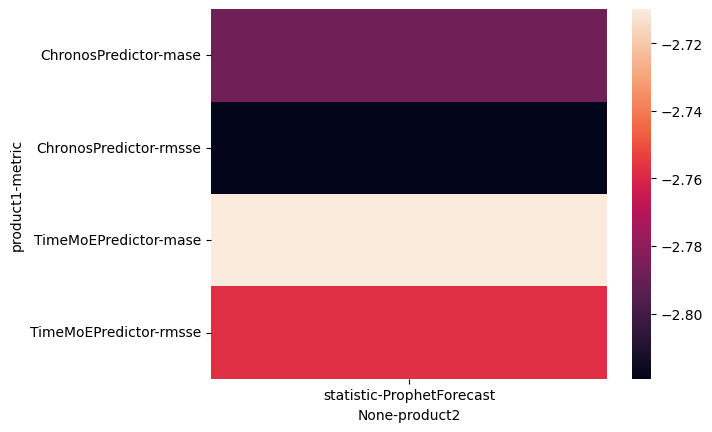

In [31]:
sns.heatmap(out.stack().unstack(level=2).loc[lambda x : x.pvalue <0.05].drop(columns="pvalue").unstack(level=1))